# commentare il programma

# Fase 1: mappare il problema sul circuito e sugli operatori

## Definisco il canale Amplitude Damping

In [57]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, DensityMatrix, partial_trace
#from qiskit.circuit.library import CRYGate
from qiskit.visualization import plot_state_qsphere
from qiskit.circuit import Parameter, ParameterVector
import numpy as np, array



def amplitude_damping_gate(theta_val):
    """
    Restituisce un gate personalizzato che rappresenta
    l'implementazione unitaria del canale amplitude damping
    su due qubit (sistema e ambiente).

    Parametri:
        theta_val (float or Parameter): angolo per la rotazione Ry

    Restituisce:
        Gate: un gate personalizzato da applicare a 2 qubit
    """
    # Crea un circuito con 2 qubit: qubit 0 = S_1, qubit 1 = E_1 (Ambiente)
    qc = QuantumCircuit(2, name="Amplitude Damping Model")

    # Applicazione delle porte
    # Applica una porta controllata-RY(θ)
    qc.cry(theta_val ,0 ,1 )# controllo su qubit 0 (S1), target qubit 1 (E1)
    qc.cx(1, 0)              # CNOT: controllo E_1 (qubit 1), target S_1 (qubit 0)

    # Converte in un Custom Gate
    gate = qc.to_gate(label="AmpDamp")
    
    return gate

theta = Parameter('θa')
example = QuantumCircuit(2)
damp_gate = amplitude_damping_gate(np.pi)
example.append(damp_gate, [0 ,1])
#example.decompose().draw("mpl")


## Definisco il canale per calcolare l'error rate

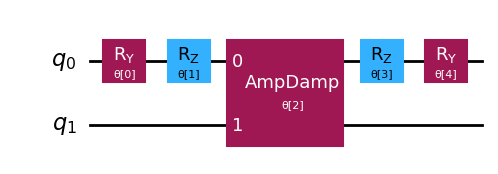

In [60]:

def build_parametrized_eradc(thetas):
    """
    Costruisce un circuito quantistico a 2 qubit con porte parametrizzate.

    Parametri:
        thetas (ParameterVector): vettore di 5 parametri [θ₀, θ₁, θa, θ₃, θ₄]

    Restituisce:
        QuantumCircuit: circuito inizializzato con le porte e parametri
    """
    if len(thetas) != 5:
        raise ValueError("Il ParameterVector deve contenere esattamente 5 parametri.")

    qc = QuantumCircuit(2, name="Error-Rate ADC Model")

    qc.ry(thetas[0], 0)                      # RY su qubit 0
    qc.rz(thetas[1], 0)                      # RZ su qubit 0

    damp_gate = amplitude_damping_gate(thetas[2])  # Amplitude damping su [0,1]
    qc.append(damp_gate, [0, 1])

    qc.rz(thetas[3], 0)                      # RZ su qubit 0
    qc.ry(thetas[4], 0)                      # RY su qubit 0

    return qc

thetas = ParameterVector('θ', 5)
ERADC = build_parametrized_eradc(thetas)
#bound_ERADC = ERADC.assign_parameters({thetas[i]: np.pi/4 for i in range(5)})
ERADC.draw('mpl')
# Visualizza il circuito
#ERADC.draw('mpl')

#ERADC.decompose("AmpDamp").draw("mpl") mostra il circuito decomposto
#print(ERADC.parameters) #permette di mostrare tutti i parametri non definiti


## Definisco lo stato iniziare del circuito nella forma di matrice densità parametrizzata

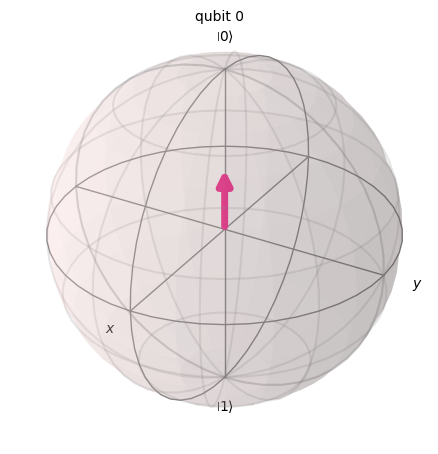

In [75]:

def initial_mixed_state_real_density_matrix(_alpha):
    # Parametro di mescolanza
    alpha = _alpha

    #creo una matrice in forma array[array[,...],...]
    rho_0_matrix = [[1 - alpha, 0],
                [0, alpha]]
    
    # Creo lo stato misto da rho_0_matrix per qubit 0
    rho_0 = DensityMatrix(rho_0_matrix)

    # creo lo stao del qubit 1 (ambiente) in |0>
    rho_1 = DensityMatrix.from_label('0')

    # Stato iniziale totale a 2 qubit
    rho_init = rho_0.tensor(rho_1)

    return rho_init

alpha = 0.3
matrix = partial_trace(initial_mixed_state_real_density_matrix(alpha),[0])
matrix.draw("bloch")



# Fase 2 evoluzione del circuito e misura con lo stato iniziale misto definito

## evoluzione del sistema